In [710]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import sys
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import random as random
import altair as alt
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime as dt
import os
import sys
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

In [3]:
dict_df = pd.read_pickle("dict_of_dfs_ver2_full.pickle")

In [4]:
dict_df = pd.read_pickle("dict_of_dfs_ver2_full.pickle")
for i in tqdm(range(len(dict_df))):
    dict_df[i]["group_id"] = i
    dict_df[i].loc[
        lambda _df: _df["train_id"] == list(dict_df[i]["train_id"].unique())[1],
        "own_group",
    ] = 1
    dict_df[i] = dict_df[i].merge(
        pd.DataFrame(
            dict_df[i]
            .loc[:, ["train_id", "self_treatment"]]
            .groupby("train_id")["self_treatment"]
            .max()
        )
        .reset_index()
        .rename(columns={"self_treatment": "treatment_somewhere"}),
        on="train_id",
        how="left",
    )
    sajt = []
    for x in list(dict_df[i].loc[:, ["trend"]]["trend"].unique()):
        sajt.append(
            dict_df[i]
            .loc[lambda _df: _df["trend"] == x, :]
            .assign(
                prop_sales_raised_train=lambda gdf: (
                    gdf["prop_sales"] * gdf["treatment_somewhere"]
                ).max()
                # sales_raised_train = lambda _df2: (_df2["seats_sold"] * _df2["treatment_smoehwere"]).max(),
            )
        )
    dict_df[i] = pd.concat(sajt)
    dict_df[i] = dict_df[i].replace(np.nan, 0)
    dict_df[i] = dict_df[i].assign(
        unqiue_train_trend_group_id=lambda _df: _df["train_id"]
        + "-"
        + str(_df["trend"])
        + "-"
        + str(_df["group_id"])
    )
    dict_df[i] = dict_df[i].assign(
        precise_treatment_period=lambda _df: _df["group_treatment"]
        + _df["self_treatment"]
    )
    dict_df[i]["treatment_in_period"] = dict_df[i]["treatment_in_period"].replace(2, 0)

100%|██████████████████████████████████████████████████████████████████████████████| 5353/5353 [05:22<00:00, 16.59it/s]


In [5]:
final_df = pd.concat(dict_df).reset_index()

In [6]:
final_df.to_parquet("analysis_df.parquet")

In [921]:
final_df = pd.read_parquet("analysis_df.parquet")

In [922]:
final_df.loc[lambda _df: _df["group_id"] == 207, ["train_id","trend","own_group","prop_sales","treatment_somewhere","prop_sales_raised_train"]]

,train_id,trend,own_group,prop_sales,treatment_somewhere,prop_sales_raised_train
8400,ALICANTEMADRID2020-03-18 06:08:002020-03-18 08...,15,0.0,0.000000,0,0.000000
8401,ALICANTEMADRID2020-03-18 07:14:002020-03-18 09...,15,1.0,0.000000,0,0.000000
8402,ALICANTEMADRID2020-03-18 08:34:002020-03-18 11...,15,0.0,0.000000,1,0.000000
8403,ALICANTEMADRID2020-03-18 06:08:002020-03-18 08...,16,0.0,0.000000,0,0.000000
8404,ALICANTEMADRID2020-03-18 07:14:002020-03-18 09...,16,1.0,0.000000,0,0.000000
...,...,...,...,...,...,...
8461,ALICANTEMADRID2020-03-18 07:14:002020-03-18 09...,36,1.0,0.193182,0,0.409091
8462,ALICANTEMADRID2020-03-18 08:34:002020-03-18 11...,36,0.0,0.409091,1,0.409091
8463,ALICANTEMADRID2020-03-18 06:08:002020-03-18 08...,37,0.0,0.542998,0,0.199017
8464,ALICANTEMADRID2020-03-18 07:14:002020-03-18 09...,37,1.0,0.257985,0,0.199017


In [923]:
final_df = final_df.loc[:,~final_df.columns.isin(["level_0", "level_1"])]

In [925]:
final_df.loc[lambda _df: _df["own_group"] == 1,:].shape

(110480, 31)

In [927]:
final_df = final_df.loc[lambda _df: _df["own_group"] == 1,:]

In [928]:
final_df.loc[:,"precise_treatment_period"] = final_df.loc[:,"precise_treatment_period"].replace(2,0)

In [929]:
final_df = final_df.sort_values(by = ["train_id","trend"])

In [930]:
final_df = final_df.merge(
    final_df.groupby("train_id").agg(maxtrend=("trend", max)).reset_index(),
    on="train_id",
    how="left",
)

In [931]:
final_df["count_precise_int"] = final_df.groupby("train_id")["precise_treatment_period"].transform(sum)

In [932]:
final_df.to_parquet("analysis_df_0416_1653.parquet")

In [933]:
final_df = pd.read_parquet("analysis_df_0416_1653.parquet")

In [935]:
trains_to_keep = final_df.groupby("train_id").agg({"precise_treatment_period": "sum"}).reset_index().loc[
    lambda _df: _df["precise_treatment_period"] < 2
]["train_id"].to_list()

In [936]:
data_aux = final_df.loc[lambda _df: _df["train_id"].isin(trains_to_keep),:].query("precise_treatment_period == 1").reset_index(drop = True)

In [937]:
final_df["precise_treatment_period"].describe()

count    110480.000000
mean          0.110708
std           0.313771
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: precise_treatment_period, dtype: float64

In [938]:
final_df.loc[lambda _df: _df["train_id"].isin(trains_to_keep),"train_id"].nunique()

2623

In [939]:
data_aux.shape

(623, 33)

In [940]:
final_df.loc[lambda _df: _df["train_id"].isin(trains_to_keep),:].shape

(38993, 33)

In [941]:
data_aux["trend_before"] = None
for i in range(1, data_aux.shape[0]):
    if (
        data_aux.loc[i, "train_id"] == data_aux.loc[i - 1, "train_id"]
    ):
        data_aux.loc[i, "trend_before"] = (
            data_aux.loc[i, "trend"] - data_aux.loc[i - 1, "trend"]
        )
    else:
        data_aux.loc[i, "trend_before"] = data_aux.loc[i, "trend"] - 1

In [942]:
data_aux["trend_after"] = None
for i in range(1, data_aux.shape[0] - 1):
    if (
        data_aux.loc[i, "train_id"] == data_aux.loc[i + 1, "train_id"]
    ):
        data_aux.loc[i, "trend_after"] = (
            data_aux.loc[i + 1, "trend"] - data_aux.loc[i, "trend"]
        )
    else:
        data_aux.loc[i, "trend_after"] = (
            data_aux.loc[i, "maxtrend"] - data_aux.loc[i, "trend"]
        )

In [943]:
data_aux

,index,train_id,trend,mean_econ_price,max_econ_seats,min_econ_seats,mean_econ_seats,depart_month,depart_day,depart_hour,...,group_id,own_group,treatment_somewhere,prop_sales_raised_train,unqiue_train_trend_group_id,precise_treatment_period,maxtrend,count_precise_int,trend_before,trend_after
0,104363,ALBACETEMADRID2020-03-03 10:38:002020-03-03 12...,22,30.50,163.0,156.0,157.444444,3,3,10,...,4,1.0,1,0.264432,ALBACETEMADRID2020-03-03 10:38:002020-03-03 12...,1,25,1,None,None
1,110177,ALBACETEMADRID2020-03-03 16:43:002020-03-03 18...,23,38.20,111.0,111.0,111.000000,3,3,16,...,6,1.0,1,0.529412,ALBACETEMADRID2020-03-03 16:43:002020-03-03 18...,1,23,1,22,0
2,110360,ALBACETEMADRID2020-03-04 16:43:002020-03-04 18...,23,38.20,91.0,91.0,91.000000,3,4,16,...,12,1.0,1,0.356207,ALBACETEMADRID2020-03-04 16:43:002020-03-04 18...,1,23,1,22,0
3,104740,ALBACETEMADRID2020-03-05 10:38:002020-03-05 12...,22,34.15,151.0,150.0,150.142857,3,5,10,...,15,1.0,1,0.418440,ALBACETEMADRID2020-03-05 10:38:002020-03-05 12...,1,23,1,21,1
4,104881,ALBACETEMADRID2020-03-06 10:38:002020-03-06 12...,22,30.50,128.0,116.0,119.125000,3,6,10,...,20,1.0,1,0.419414,ALBACETEMADRID2020-03-06 10:38:002020-03-06 12...,1,25,1,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,103120,ZARAGOZAMADRID2020-03-25 16:26:002020-03-25 17...,21,41.80,18.0,18.0,18.000000,3,25,16,...,5304,1.0,1,0.322581,ZARAGOZAMADRID2020-03-25 16:26:002020-03-25 17...,1,37,1,20,16
619,91475,ZARAGOZAMADRID2020-03-28 13:43:002020-03-28 15...,19,41.80,268.0,268.0,268.000000,3,28,13,...,5322,1.0,0,0.800000,ZARAGOZAMADRID2020-03-28 13:43:002020-03-28 15...,1,37,1,18,18
620,115343,ZARAGOZAMADRID2020-03-28 18:26:002020-03-28 19...,23,41.80,243.0,243.0,243.000000,3,28,18,...,5326,1.0,1,1.000000,ZARAGOZAMADRID2020-03-28 18:26:002020-03-28 19...,1,37,1,22,14
621,35562,ZARAGOZAMADRID2020-03-29 11:43:002020-03-29 13...,8,41.80,182.0,179.0,180.750000,3,29,11,...,5333,1.0,1,0.867782,ZARAGOZAMADRID2020-03-29 11:43:002020-03-29 13...,1,37,1,7,29


#### Treatment indicator, a treatment előtti 5 és utáni 5 napban

In [944]:
data_aux["intervention"] = np.where(
    (data_aux["trend_before"] < 18) | (data_aux["trend_after"] < 18),
    0,
    data_aux["precise_treatment_period"],
)

In [945]:
data_aux = data_aux[["train_id","trend", "intervention"]]

In [946]:
data_balanced = final_df.loc[lambda _df: _df["train_id"].isin(trains_to_keep),:].merge(data_aux, on = ["train_id","trend"], how = "left")

In [947]:
data_balanced["intervention"] = data_balanced["intervention"].fillna(0)

In [948]:
data_balanced["intervention"].value_counts()

0.0    38965
1.0       28
Name: intervention, dtype: int64

In [949]:
data_balanced = data_balanced.merge(
    data_balanced.groupby("train_id")
    .agg(countinterv=("intervention", "sum"))
    .reset_index(),
    on=["train_id"],
    how="left",
)

In [950]:
data_balanced["countinterv"].value_counts()

0.0    38240
1.0      753
Name: countinterv, dtype: int64

In [951]:
data_balanced["countinterv"].describe()

count    38993.000000
mean         0.019311
std          0.137618
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: countinterv, dtype: float64

In [952]:
data_balanced["intervention"].describe()

count    38993.000000
mean         0.000718
std          0.026788
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: intervention, dtype: float64

In [953]:
data_balanced["intervention"].value_counts()

0.0    38965
1.0       28
Name: intervention, dtype: int64

In [954]:
data_balanced = data_balanced.merge(
    data_balanced.groupby("train_id")
    .apply(lambda x: np.nanmin(np.where(x["intervention"] == 1, x["trend"], np.nan)))
    .reset_index()
    .rename(columns={0: "intervention_time"}),
    on="train_id",
    how="left",
)

In [955]:
data_balanced["intervention_time"].value_counts()

19.0    683
20.0     36
37.0     24
22.0     10
Name: intervention_time, dtype: int64

In [956]:
(
    data_balanced.groupby(["train_id", "trend"])
    .apply(
        lambda x: np.where(
            np.isfinite(x["intervention_time"]),
            x["trend"] - x["intervention_time"],
            np.nan,
        )[0]
    )
    .reset_index()
    .rename(columns={0: "t_event"})
).sort_values(by = "t_event").head()

,train_id,trend,t_event
35386,ZARAGOZAMADRID2020-03-30 15:43:002020-03-30 17...,3,-34.0
35387,ZARAGOZAMADRID2020-03-30 15:43:002020-03-30 17...,4,-33.0
35388,ZARAGOZAMADRID2020-03-30 15:43:002020-03-30 17...,5,-32.0
35389,ZARAGOZAMADRID2020-03-30 15:43:002020-03-30 17...,6,-31.0
35390,ZARAGOZAMADRID2020-03-30 15:43:002020-03-30 17...,7,-30.0


In [957]:
data_balanced = data_balanced.merge(
    data_balanced.groupby(["train_id", "trend"])
    .apply(
        lambda x: np.where(
            np.isfinite(x["intervention_time"]),
            x["trend"] - x["intervention_time"],
            np.nan,
        )[0]
    )
    .reset_index()
    .rename(columns={0: "t_event"}),
    on=["train_id", "trend"],
    how="left",
)

In [958]:
data_balanced.loc[
    lambda _df: _df["intervention_time"] > 0,
    ["train_id","trend", "intervention_time"],
].head()

,train_id,trend,intervention_time
8,ALBACETEMADRID2020-03-03 10:38:002020-03-03 12...,15,22.0
9,ALBACETEMADRID2020-03-03 10:38:002020-03-03 12...,16,22.0
10,ALBACETEMADRID2020-03-03 10:38:002020-03-03 12...,17,22.0
11,ALBACETEMADRID2020-03-03 10:38:002020-03-03 12...,19,22.0
12,ALBACETEMADRID2020-03-03 10:38:002020-03-03 12...,20,22.0


In [959]:
data_balanced.shape

(38993, 37)

In [960]:
data_balanced.drop_duplicates().shape

(38993, 37)

In [961]:
data_balanced_nondup = data_balanced.drop_duplicates(subset = ["train_id","trend"])

In [962]:
data_balanced_nondup.groupby(["train_id","trend"]).mean().reset_index().head()

,train_id,trend,index,mean_econ_price,max_econ_seats,min_econ_seats,mean_econ_seats,depart_month,depart_day,depart_hour,...,own_group,treatment_somewhere,prop_sales_raised_train,precise_treatment_period,maxtrend,count_precise_int,intervention,countinterv,intervention_time,t_event
0,ALBACETEMADRID2020-03-02 09:32:002020-03-02 11...,15,64411.0,34.150000,153.0,153.0,153.000000,3.0,2.0,9.0,...,1.0,1.0,0.00000,0.0,17.0,0.0,0.0,0.0,NaN,NaN
1,ALBACETEMADRID2020-03-02 09:32:002020-03-02 11...,16,71311.0,35.254545,152.0,146.0,149.818182,3.0,2.0,9.0,...,1.0,1.0,0.43750,0.0,17.0,0.0,0.0,0.0,NaN,NaN
2,ALBACETEMADRID2020-03-02 09:32:002020-03-02 11...,17,78191.0,37.621429,146.0,141.0,143.714286,3.0,2.0,9.0,...,1.0,1.0,0.54023,0.0,17.0,0.0,0.0,0.0,NaN,NaN
3,ALBACETEMADRID2020-03-02 13:38:002020-03-02 15...,15,64413.0,38.200000,157.0,155.0,156.000000,3.0,2.0,13.0,...,1.0,0.0,0.00000,0.0,17.0,0.0,0.0,0.0,NaN,NaN
4,ALBACETEMADRID2020-03-02 13:38:002020-03-02 15...,16,71313.0,38.200000,152.0,141.0,148.909091,3.0,2.0,13.0,...,1.0,0.0,0.00000,0.0,17.0,0.0,0.0,0.0,NaN,NaN


In [963]:
data_balanced_nondup.loc[:,"t_event"] = data_balanced_nondup.loc[:,"t_event"].apply(lambda x: np.where((x >= 0) & (x <= 38),x+1,x))

In [964]:
data_balanced = data_balanced_nondup

In [965]:
data_balanced["countinterv"].value_counts()

0.0    34773
1.0      753
Name: countinterv, dtype: int64

In [966]:
data_balanced["intervention"].value_counts()

0.0    35498
1.0       28
Name: intervention, dtype: int64

In [967]:
data_balanced.groupby(["intervention","countinterv"]).count()["index"]

intervention  countinterv
0.0           0.0            34773
              1.0              725
1.0           1.0               28
Name: index, dtype: int64

In [968]:
data_balanced_szar = data_balanced.query(
    "(countinterv == 1 & t_event >= -18 & t_event <= 18) | count_precise_int == 0"
)

In [969]:
data_balanced_szar["intervention"].value_counts()

0.0    25925
1.0       28
Name: intervention, dtype: int64

In [970]:
data_balanced.groupby("countinterv").apply(
    lambda x: x.groupby(["train_id"]).ngroups
)

countinterv
0.0    2595
1.0      28
dtype: int64

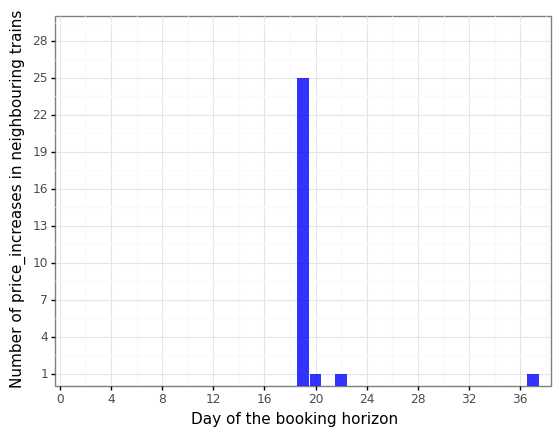

<ggplot: (123223523920)>

In [971]:
ggplot(data_balanced, aes(x="trend", y="intervention")) + geom_col(
    fill="blue", size=0.25, alpha=0.8, show_legend=False
) + labs(y="Number of price_increases in neighbouring trains", x="Day of the booking horizon") + scale_y_continuous(
    expand=(0.0, 0.0), breaks=np.arange(1, 30, 3), limits=(0, 30)
) + scale_x_continuous(
    expand=(0.01, 0.01), breaks=np.arange(0, 38, 4), limits=(0, 38)
) + theme_bw()

In [972]:
# figure: average number interventions by game number
p = (
    ggplot(data_balanced, aes(x="trend", y="intervention"))
    + geom_col(fill="teal", size=0.25, alpha=0.8, show_legend=False)
    + labs(
        y="Number of price_increases in neighbouring trains",
        x="Day of the booking horizon",
    )
    + scale_y_continuous(expand=(0.0, 0.0), breaks=np.arange(1, 30, 3), limits=(0, 30))
    + scale_x_continuous(
        expand=(0.01, 0.01), breaks=np.arange(0, 38, 4), limits=(0, 38)
    )
    + theme_bw()
)

p.save(filename="distribution_treatment.png", height=5, width=5, units="in", dpi=1000)

In [973]:
(data_balanced.groupby("t_event").agg(mean=("prop_sales", "mean")).reset_index()).describe()

,t_event,mean
count,54.000000,54.000000
mean,-7.129630,0.274657
std,16.142112,0.188736
min,-34.000000,0.000000
25%,-20.750000,0.165836
50%,-7.500000,0.274252
75%,6.750000,0.337243
max,20.000000,1.000000


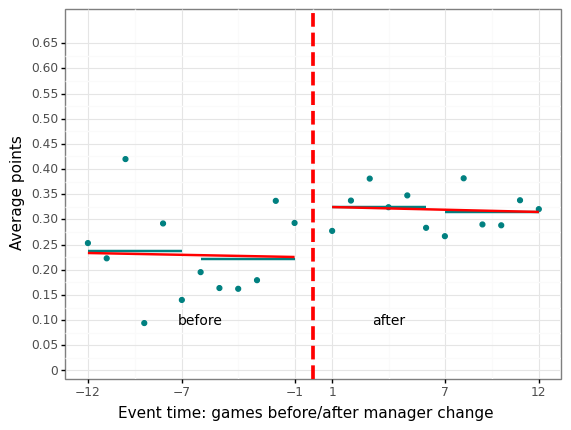

<ggplot: (123225801804)>

In [974]:
data_plot = (
    data_balanced.groupby("t_event")
    .agg(mean=("prop_sales", "mean"))
    .reset_index()
    .assign(
        t_event_9=lambda df: pd.cut(
            df["t_event"], bins=[-12, -6, 0, 1, 7, 13], right=False
        )
    )
)
data_plot = data_plot.merge(
    data_plot.groupby("t_event_9").agg(group_mean=("mean", "mean")),
    on="t_event_9",
    how="left",
)

(
    ggplot(data_plot, aes(x="t_event", y="mean"))
    + geom_point(color="teal")
    + geom_line(
        aes(x="t_event", y="group_mean", group="t_event_9"),
        size=1,
        color="teal",
    )
    + geom_vline(xintercept=0, color="red", size=1.5, linetype="dashed")
    + labs(y="Average points", x="Event time: games before/after manager change")
    + geom_smooth(
        mapping=data_plot.loc[lambda _df: _df["t_event"] > 0, :],
        method="lm",
        color="red",
        se=False,
    )
    + geom_smooth(
        mapping=data_plot.loc[lambda _df: _df["t_event"] < 0, :],
        method="lm",
        color="red",
        se=False,
    )
    + scale_x_continuous(breaks=(-12, -7, -1, 1, 7, 12), limits=(-12, 12))
    + scale_y_continuous(
        expand=(0.01, 0.01), breaks=np.arange(0, 0.7, 0.05), limits=(0, 0.7)
    )
    + annotate("text", x=4, y=0.1, label="after", size=10)
    + annotate("text", x=-6, y=0.1, label="before", size=10)
    + theme_bw()
)

In [975]:
data_plot = (
    data_balanced.groupby("t_event")
    .agg(mean=("prop_sales", "mean"))
    .reset_index()
    .assign(
        t_event_9=lambda df: pd.cut(
            df["t_event"], bins=[-12, -6, 0, 1, 7, 13], right=False
        )
    )
)
data_plot = data_plot.merge(
    data_plot.groupby("t_event_9").agg(group_mean=("mean", "mean")),
    on="t_event_9",
    how="left",
)

p = (
    ggplot(data_plot, aes(x="t_event", y="mean"))
    + geom_point(color="teal")
    + geom_line(
        aes(x="t_event", y="group_mean", group="t_event_9"),
        size=1,
        color="teal",
    )
    + geom_vline(xintercept=0, color="darkred", size=1.5, linetype="dashed")
    + labs(y="Average proportion of sales", x="Event time: days before/after treatment")
    + scale_x_continuous(breaks=(-12, -7, -1, 1, 7, 12), limits=(-12, 12))
    + scale_y_continuous(
        expand=(0.01, 0.01), breaks=np.arange(0, 0.7, 0.05), limits=(0, 0.7)
    )
    + annotate("text", x=4, y=0.68, label="After", size=10)
    + annotate("text", x=-4, y=0.68, label="Before", size=10)
    + theme_bw()
)

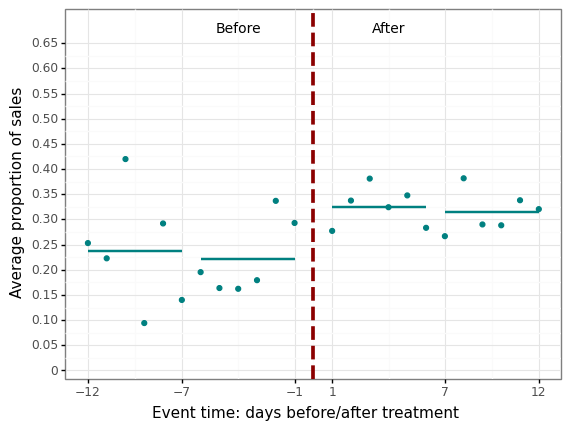

<ggplot: (123109533012)>

In [976]:
p

In [977]:
p.save(filename="Firsteventstudy.png", height=5, width=5, units="in", dpi=1000)

In [978]:
# for each game, define avg diff of points 12-7 before
# dip: avg diff of points 6-1 before minus 12-7 before


data_balanced["prop_sales_r_b_6_12"] = (
    data_balanced.sort_values(by=["train_id", "trend"])
    .groupby(["train_id"])["prop_sales_raised_train"]
    .apply(
        lambda x: (x.shift(7)
        + x.shift(8)
        + x.shift(9)
        + x.shift(10)
        + x.shift(11)
        + x.shift(12)) / 6,
    )
)


data_balanced["prop_sales_r_b_1_6"] = (
    data_balanced.sort_values(by=["train_id", "trend"])
    .groupby(["train_id"])["prop_sales_raised_train"]
    .apply(
        lambda x: (x.shift(6)
        + x.shift(5)
        + x.shift(4)
        + x.shift(3)
        + x.shift(2)
        + x.shift(1)) / 6,
    )
)


data_balanced["prop_sales_r_b_12_18"] = (
    data_balanced.sort_values(by=["train_id", "trend"])
    .groupby(["train_id"])["prop_sales_raised_train"]
    .apply(
        lambda x: (x.shift(13)
        + x.shift(14)
        + x.shift(15)
        + x.shift(16)
        + x.shift(17)
        + x.shift(18)) / 6,
    )
)

####
data_balanced["prop_sales_b_6_12"] = (
    data_balanced.sort_values(by=["train_id", "trend"])
    .groupby(["train_id"])["prop_sales"]
    .apply(
        lambda x:( x.shift(7)
        + x.shift(8)
        + x.shift(9)
        + x.shift(10)
        + x.shift(11)
        + x.shift(12)) / 6,
    )
)


data_balanced["prop_sales_b_1_6"] = (
    data_balanced.sort_values(by=["train_id", "trend"])
    .groupby(["train_id"])["prop_sales"]
    .apply(
        lambda x: (x.shift(6)
        + x.shift(5)
        + x.shift(4)
        + x.shift(3)
        + x.shift(2)
        + x.shift(1)) / 6,
    )
)


data_balanced["prop_sales_b_12_18"] = (
    data_balanced.sort_values(by=["train_id", "trend"])
    .groupby(["train_id"])["prop_sales"]
    .apply(
        lambda x: (x.shift(13)
        + x.shift(14)
        + x.shift(15)
        + x.shift(16)
        + x.shift(17)
        + x.shift(18)) / 6,
    )
)


data_balanced = data_balanced.assign(
    dip1_r=lambda df: df["prop_sales_r_b_1_6"]- df["prop_sales_r_b_6_12"],
    dip12_r=lambda df: df["prop_sales_r_b_6_12"] - df["prop_sales_r_b_12_18"],
).assign(prop_sales_r_b1=lambda df: df["prop_sales_raised_train"].shift(1))

data_balanced = data_balanced.assign(
    dip1=lambda df: df["prop_sales_b_1_6"] - df["prop_sales_b_6_12"],
    dip12=lambda df: df["prop_sales_b_6_12"] - df["prop_sales_b_12_18"],
).assign(prop_sales_b1=lambda df: df["prop_sales"].shift(1))

In [979]:
# summary stats of dip when intervention
data_balanced.query("intervention == 1")[
    ["prop_sales_r_b_1_6", "prop_sales_r_b_6_12",  "dip1_r", "prop_sales_r_b_12_18", "dip12_r", "prop_sales_r_b1"]
].describe()

,prop_sales_r_b_1_6,prop_sales_r_b_6_12,dip1_r,prop_sales_r_b_12_18,dip12_r,prop_sales_r_b1
count,17.000000,12.000000,12.000000,1.000000,1.000000,28.000000
mean,0.545690,0.388711,0.119246,0.476366,-0.143033,0.308309
std,0.199008,0.148966,0.188770,NaN,NaN,0.367105
min,0.226836,0.049020,-0.084828,0.476366,-0.143033,0.000000
25%,0.437336,0.327916,-0.013455,0.476366,-0.143033,0.000000
50%,0.510806,0.412618,0.046406,0.476366,-0.143033,0.125652
75%,0.678314,0.466054,0.227764,0.476366,-0.143033,0.565156
max,0.981907,0.633939,0.450980,0.476366,-0.143033,1.000000


In [980]:
# summary stats of dip when intervention
data_balanced.query("intervention == 1")[
    ["prop_sales_b_1_6", "prop_sales_b_6_12",  "dip1", "prop_sales_b_12_18", "dip12", "prop_sales_b1"]
].describe()

,prop_sales_b_1_6,prop_sales_b_6_12,dip1,prop_sales_b_12_18,dip12,prop_sales_b1
count,17.000000,12.000000,12.000000,1.00000,1.00000,28.000000
mean,0.233290,0.221290,0.033329,0.34916,-0.34916,0.337421
std,0.169824,0.215462,0.223061,NaN,NaN,0.390267
min,0.000000,0.000000,-0.351040,0.34916,-0.34916,0.000000
25%,0.137842,0.037864,-0.067623,0.34916,-0.34916,0.000000
50%,0.210419,0.162674,0.011985,0.34916,-0.34916,0.171666
75%,0.260958,0.382621,0.124092,0.34916,-0.34916,0.652155
max,0.567767,0.628835,0.567767,0.34916,-0.34916,1.000000


In [981]:
# set ranges to define control group based on raised_train
points_r_b_7_12min = 0
points_r_b_7_12max = 3.77
points_r_b_1_6min = 0.225
points_r_b_1_6max = 0.82
dipmin_r = -.35
dipmax_r = .056
points_r_b_1min = 0
points_r_b_1max = 1
# set ranges to define control group based on own data
points_b_7_12min = 0.293
points_b_7_12max = 3.804
points_b_1_6min = 0
points_b_1_6max = 0.57
dipmin = -.085
dipmax = .451
points_b_1min = 0
points_b_1max = 1

In [982]:
data_balanced.shape

(35526, 49)

In [983]:
data_balanced["pseudo"] = np.where(
    (data_balanced["precise_treatment_period"] == 0)
    & (data_balanced["dip1"] >= dipmin)
    & (data_balanced["dip1"] <= dipmax)
    & (data_balanced["prop_sales_b_6_12"] >= points_b_7_12min)
    & (data_balanced["prop_sales_b_6_12"] <= points_b_7_12max)
    & (data_balanced["prop_sales_b_1_6"] >= points_b_1_6min)
    & (data_balanced["prop_sales_b_1_6"] <= points_b_1_6max)
    & (data_balanced["prop_sales_b1"] >= points_b_1min)
    & (data_balanced["prop_sales_b1"] <= points_b_1max)
    & (data_balanced["trend"] < (38 - 12))
    & (data_balanced["dip1_r"] >= dipmin_r)
    & (data_balanced["dip1_r"] <= dipmax_r)
    & (data_balanced["prop_sales_r_b_6_12"] >= points_r_b_7_12min)
    & (data_balanced["prop_sales_r_b_6_12"] <= points_r_b_7_12max)
    & (data_balanced["prop_sales_r_b_1_6"] >= points_r_b_1_6min)
    & (data_balanced["prop_sales_r_b_1_6"] <= points_r_b_1_6max)
    & (data_balanced["prop_sales_r_b1"] >= points_r_b_1min)
    & (data_balanced["prop_sales_r_b1"] <= points_r_b_1max),
    1,
    0,
)

In [984]:
data_balanced.shape

(35526, 50)

In [985]:
data_balanced["pseudo"].value_counts(dropna=False)

0    35018
1      508
Name: pseudo, dtype: int64

In [986]:
data_balanced.query("pseudo == 1")[["prop_sales_b_6_12", "dip1", "prop_sales_b1"]].describe()

,prop_sales_b_6_12,dip1,prop_sales_b1
count,508.000000,508.000000,508.000000
mean,0.394231,0.008136,0.382212
std,0.073689,0.071196,0.292848
min,0.293301,-0.084821,0.000000
25%,0.333333,-0.045210,0.148434
50%,0.378755,-0.005660,0.353238
75%,0.445906,0.041682,0.563203
max,0.618487,0.255701,1.000000


In [987]:
data_balanced = data_balanced.merge(
    data_balanced.groupby(["train_id"])
    .agg(countpseudo=("pseudo", sum))
    .reset_index(),
    on=["train_id"],
    how="left",
)

In [988]:
data_balanced = data_balanced.merge(
    data_balanced.groupby(["train_id"])
    .apply(lambda x: np.nanmin(np.where(x["pseudo"] == 1, x["trend"], np.nan)))
    .reset_index()
    .rename(columns={0: "pseudo_time"}),
    on=["train_id"],
    how="left",
)

In [990]:
data_balanced = data_balanced.merge(
    data_balanced.groupby(["train_id","trend"])
    .apply(
        lambda x: np.where(
            np.isfinite(x["pseudo_time"]),
            x["trend"] - x["pseudo_time"],
            np.nan,
        )[0]
    )
    .reset_index()
    .rename(columns={0: "t_pseudo"}),
    on=["train_id","trend"],
    how="left",
)

In [991]:
data_balanced.loc[:, "t_pseudo"] = data_balanced.loc[:, "t_pseudo"].apply(
    lambda x: np.where((x >= 0) & (x <= 38), x + 1, x)
)

In [992]:
data_balanced = (
    data_balanced.merge(
        data_balanced.groupby(["train_id", "trend"])
        .apply(
            lambda x: np.where(
                np.isnan(x["t_event"]),
                x["t_pseudo"],
                x["t_event"],
            )[0]
        )
        .reset_index()
        .rename(columns={0: "t_event"}),
        on=["train_id", "trend"],
        how="left",
    )
    .drop(columns=["t_event_x"])
    .rename(columns={"t_event_y": "t_event"})
)

In [993]:
data_balanced = data_balanced.query(
    "(t_event >= -12 & t_event <= 12)"
)

In [994]:
(
    data_balanced.loc[lambda _df: _df["countpseudo"].isin([0, 1])]
    .groupby(["countinterv", "countpseudo"])
    .apply(lambda x: x.groupby(["train_id"]).ngroups)
)

countinterv  countpseudo
0.0          1              89
1.0          0              23
             1               3
dtype: int64

In [995]:
data_balanced_legit = data_balanced.assign(summa = lambda x: x["countpseudo"] + x["countinterv"]).query("summa != 2")

In [1191]:
data_plot = (
    data_balanced.loc[lambda _df: _df["countpseudo"].isin([0, 1])]
    .groupby(["t_event", "countinterv", "countpseudo"])
    .agg(mean=("prop_sales", "mean"))
    .reset_index()
    .assign(
        t_event_6=lambda df: pd.cut(
            df["t_event"], bins=[-10, -5, 0, 1, 6, 11], right=False
        )
    )
)
data_plot = data_plot.merge(
    data_plot.groupby(["t_event_6", "countpseudo"]).agg(group_mean=("mean", "mean")),
    on=["t_event_6", "countpseudo"],
    how="left",
)
data_plot["countpseudo"] = data_plot["countpseudo"].astype("category")

p = (
    ggplot(data_plot, aes(x="t_event", y="mean", color="countpseudo"))
    + geom_point(alpha=0.5)
    + geom_line(
        data_plot.query("countpseudo == 0"),
        aes(x="t_event", y="group_mean", group="t_event_6"),
        size=1,
        alpha=0.5,
    )
    + geom_line(
        data_plot.query("countpseudo == 1"),
        aes(x="t_event", y="group_mean", group="t_event_6"),
        size=1,
        alpha=0.5
        # ) + geom_smooth(mapping = data_plot.loc[lambda _df: _df["t_event"] > 0,:], method = "lm", se = False
    )
    + geom_smooth(
        mapping=data_plot.loc[lambda _df: _df["t_event"] < 0, :],
        method="lm",
        se=False,
        linetype="dashed",
    )
    + scale_color_manual(
        values=["teal", "darkred"],
        name=" ",
        labels=("intervention", "pseudo intervention"),
    )
    + geom_vline(
        xintercept=0,
        color="darkred",
        size=1.5,
        linetype="dashed"
        # ) + labs(
        #    y="Average points", x="Event time: games before/after manager change"
    )
    + scale_x_continuous(breaks=(-12, -6, -1, 1, 6, 12), limits=(-10, 10))
    + scale_y_continuous(
        expand=(0.01, 0.01),
        breaks=np.arange(0, 0.7, 0.05),
        limits=(0, 0.7)
        # ) + annotate(
        #    "text", x=4, y=0.1, label="after", size=10
        # ) + annotate(
        #    "text", x=-6, y=0.1, label="before", size=10
    )
    + theme_bw()
)

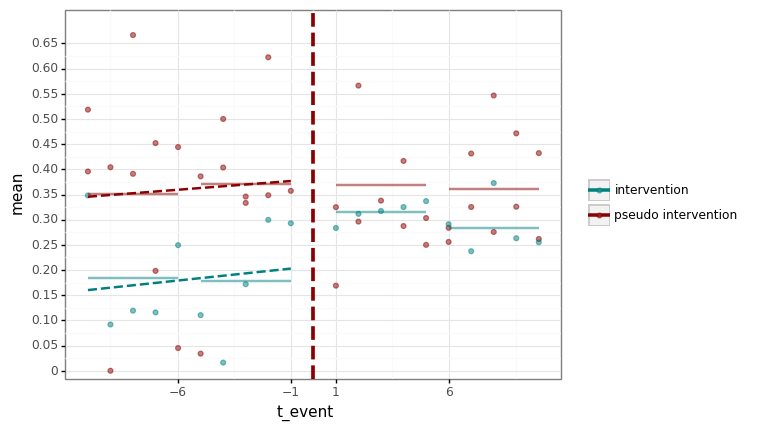

<ggplot: (123227177912)>

In [1192]:
p

In [1056]:
p.save(filename="eventstudywithpseudo.png", height=5, width=5, units="in", dpi=1000)

In [1057]:
#repl = data_balanced.query("countinterv == 1 or countpseudo == 1").query(
#    "t_event < 1 & t_event > -11"
#).rename(columns = {"countinterv":"Treated"})

#repl["Treated"] = repl["Treated"].astype(str)

p = (
    ggplot(data_plot, aes(x="t_event", y="mean", color="countpseudo"))
    + geom_point()
    + scale_color_manual(
        values=["teal", "darkred"],
        name=" ",
        labels=("intervention", "pseudo intervention"),
    )
    + labs(y="Proportion of sales", x="Event time before treatment")
    + scale_x_continuous(breaks=np.arange(-12, 1, 1), limits=(-10, -1))
    + scale_y_continuous(
        expand=(0.01, 0.01), breaks=np.arange(0, 1, 0.1), limits=(0, 1)
    )
    + geom_smooth(method="lm", se=False)
    + theme_bw()
)

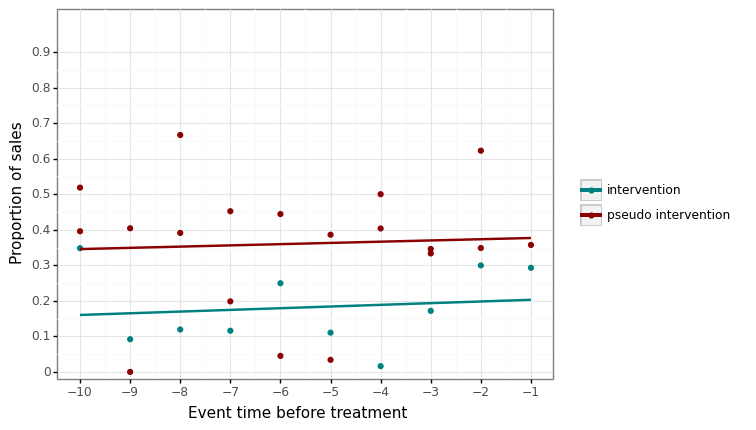

<ggplot: (123109565552)>

In [1058]:
p

In [1059]:
p.save(filename="paralell.png", height=5, width=5, units="in", dpi=1000)

In [1060]:
data_ = data_balanced.query("countpseudo < 2").assign(summa = lambda _df:_df["countinterv"]+_df["countpseudo"]).query("summa == 1")

In [1066]:
figdata = data_shithead.loc[:,["prop_sales", "t_event","countpseudo"]]

In [1068]:
figdata.dropna()

,prop_sales,t_event,countpseudo
8,0.000000,-7.0,0
9,0.315789,-6.0,0
10,0.000000,-5.0,0
11,0.234466,-3.0,0
12,0.319149,-2.0,0
...,...,...,...
35255,0.065934,-1.0,1
35256,0.000000,1.0,1
35407,0.473684,-12.0,0
35408,0.279070,-11.0,0


In [1070]:
data_plot.dropna()

,t_event,countinterv,countpseudo,mean,t_event_6,group_mean
6,-10.0,0.0,1,0.395743,"[-10, -5)",0.351605
7,-10.0,1.0,0,0.348131,"[-10, -5)",0.184939
8,-10.0,1.0,1,0.518519,"[-10, -5)",0.351605
9,-9.0,0.0,1,0.404195,"[-10, -5)",0.351605
10,-9.0,1.0,0,0.091880,"[-10, -5)",0.184939
11,-9.0,1.0,1,0.000000,"[-10, -5)",0.351605
12,-8.0,0.0,1,0.391059,"[-10, -5)",0.351605
13,-8.0,1.0,0,0.119384,"[-10, -5)",0.184939
14,-8.0,1.0,1,0.666667,"[-10, -5)",0.351605
15,-7.0,0.0,1,0.452123,"[-10, -5)",0.351605


### Regressziók

In [1107]:
regdata = (
    data_balanced.assign(
        t6_event=lambda df: pd.cut(
            df["t_event"], bins=[-12, -6, 0, 1, 7, 13], right=False
        )
    )
    .groupby(["train_id", "t6_event"])
    .agg(treated=("countpseudo", "mean"), prop_values6avg=("prop_sales", "mean"))
    .reset_index()
    .dropna()
    .assign(
        Dp6avg=lambda df: df.groupby("train_id")["prop_values6avg"].transform("diff")
    )
)
regdata.head()

,train_id,t6_event,treated,prop_values6avg,Dp6avg
0,ALBACETEMADRID2020-03-03 10:38:002020-03-03 12...,"[-12, -6)",0.0,0.000000,NaN
1,ALBACETEMADRID2020-03-03 10:38:002020-03-03 12...,"[-6, 0)",0.0,0.232467,0.232467
3,ALBACETEMADRID2020-03-03 10:38:002020-03-03 12...,"[1, 7)",0.0,0.334463,0.101996
5,BARCELONAMADRID2020-03-06 08:25:002020-03-06 1...,"[-12, -6)",1.0,0.288862,NaN
6,BARCELONAMADRID2020-03-06 08:25:002020-03-06 1...,"[-6, 0)",1.0,0.073131,-0.215731


In [1226]:
regdataR = data_balanced.query("countpseudo == 1 or countpseudo == 0").loc[lambda _df: (_df["t_event"] > -11) & (_df["t_event"] < 11), :]
regdataR = (
    regdataR
    .groupby(["train_id", "t_event"])
    .agg(
        treated=("countinterv", "mean"),
        price=("mean_econ_price", "mean"),
        prop_sales=("prop_sales", "mean"),
        seats_sold=("seats_sold", "mean"),
    )
    .reset_index()
    .assign(
        t6_event=lambda df: pd.cut(
            df["t_event"], bins=[-10, -5, 0, 1, 6, 12], right=False
        )
    )
    .reset_index()
)
regdataR["t6_event_str"] = regdataR["t6_event"].astype(str)

In [1225]:
regdataR["t6_event_str"].value_counts().to_dict()

{'[1, 6)': 464, '[-10, -5)': 460, '[-5, 0)': 439, '[6, 12)': 431, 'nan': 258}

In [1227]:
regdataR["t6_event_str"].value_counts().to_dict()
replace_dict4 = {'[1, 6)': 3, '[-10, -5)': 1, '[-5, 0)': 2, '[6, 12)': 4}

In [1228]:
regdataR["t6_event_str"] = regdataR["t6_event_str"].replace(replace_dict4)

In [1266]:
trains_to_keep2 = (
    regdataR.groupby("train_id")
    .agg(first_t=("t_event", "first"), last_t=("t_event", "last"))
    .reset_index()
    .query("first_t < -5 and last_t > 5")["train_id"]
    .to_list()
)

In [1277]:
regdataR.loc[
    lambda _df: _df["train_id"].isin(trains_to_keep2),
    [
        "train_id",
        "t_event",
        "treated",
        "price",
        "prop_sales",
        "seats_sold",
        "t6_event_str",
    ],
].to_csv("regdataR3.csv")